In [1]:
#import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import seaborn as sns

%matplotlib inline

#import conviction files
#from conviction_helpers import *
#from conviction_system_logic3 import *
from bonding_curve_eq import *

System initialization

In [2]:
hatch_raise = 100000 # fiat units
hatch_price = .1 #fiat per tokens
theta = .5 #share of funds going to funding pool at launch

R0 = hatch_raise*(1-theta)
F0 = hatch_raise*theta
S0 = hatch_raise/hatch_price

kappa = 2
V0 = invariant(R0,S0,kappa)
P0 = spot_price(R0, V0, kappa)

dust = 10**-8

agent initialization

In [3]:
#number of agents
n= 100

#gain factors
g = np.random.normal(2, .5, size=n)
phat0 = g*F0/S0 #derivative, integral and proportion
#agents as controllers, co-steering

#wakeup rates
gamma =  sts.expon.rvs(loc=1,scale=5, size=n)

#copy_cat_sensitivity
nu = .5*np.random.rand(n)

#holdings fiat
h = sts.expon.rvs( loc=100,scale=1000, size=n)

#holdings tokens
s_dist = sts.expon.rvs(loc=10, scale=10, size=n)
s0 = s_dist/sum(s_dist)*S0

#lambda for revenue process
lam = 200

#phi for exiting funds
phi = .05

#beta is param for armijo rule
beta = .9

(array([14., 11.,  9., 10.,  8., 10., 10., 12.,  8.,  8.]),
 array([0.00138631, 0.05054949, 0.09971266, 0.14887584, 0.19803902,
        0.2472022 , 0.29636538, 0.34552856, 0.39469173, 0.44385491,
        0.49301809]),
 <a list of 10 Patch objects>)

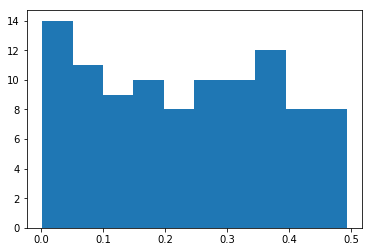

In [4]:
plt.hist(nu)

In [5]:
params= {
    'kappa': [kappa],
    'lambda': [lam],
    'gains': [g],
    'copy_wt':[nu],
    'rates':[1/gamma],
    'population':[n],
    'beta':[beta],
    'phi': [phi],
    'invariant': [V0],
    'dust' : [dust]}

In [6]:
initial_conditions = {'holdings': h,
                      'tokens': s0,
                      'supply': S0,
                      'prices': phat0,
                      'funds':F0,
                      'reserve': R0,
                      'spot_price': P0,
                      'actions': {}}

In [7]:
initial_conditions

{'actions': {},
 'funds': 50000.0,
 'holdings': array([ 736.24804104,  282.54517218, 3040.80699337,  238.29200059,
         193.68918034,  144.91631681,  315.22143539,  527.65477299,
         316.55580683,  449.8114287 , 2039.87432819,  938.7898018 ,
         137.62212507,  193.02007489, 1029.59194525,  198.58194666,
         516.84172832, 1376.82557549,  925.49901934,  618.55295627,
        1401.63799281, 1597.3941186 ,  104.23834524, 1649.64224589,
        1373.72334367,  257.11580653,  828.10992001,  768.24772969,
         224.87830295,  969.00844016,  918.71837889,  910.39391321,
        1512.35978146, 1959.3132925 ,  900.59257776,  141.89285306,
         796.95217752, 4149.94119104,  830.0988348 , 1216.45030126,
        1584.74084265,  110.06147541,  198.9885803 ,  685.58595916,
        1338.45215261,  159.01372186, 2363.13478701, 1727.18748489,
         518.39622804,  936.02133175,  115.64967442, 3552.75356032,
        1282.15502716,  742.54742804,  617.2132287 , 1448.51166242,
 

In [8]:
#change in F (revenue and spending accounted for)
def revenue_process(params, step, sL, s):
    lam = params['lambda']
    rv = sts.expon.rvs(loc = 0, scale=1/lam)
    delF= 1-1/lam+rv
    
    #avoid the crash (temporary hacks, tune martingale process better)
    #if delF <1:
    #    if s['funds'] <1000:
    #        delF =100
    
    return({'delF':delF})

In [9]:
def update_funds(params, step, sL, s, _input):
    
    funds = s['funds']*_input['delF']
    
    key = 'funds'
    value = funds
    
    return (key, value)

In [10]:
def update_prices(params, step, sL, s, _input):
    
    #can also add a term for extrapolating the trend
    g = params['gains']
    nu = params['copy_wt']
    phat = g*s['funds']/s['supply']*(1-nu)+ nu*s['spot_price']
    
    key = 'prices'
    value = phat
    
    return (key, value)

In [11]:
#change in F (revenue and spending accounted for)
def choose_agents(params, step, sL, s):
    n = params['population']
    rates = params['rates']
    
    agents = []
    for a in range(n):
        sq_gap = (s['spot_price']-s['prices'][a])**2
        pr = (rates[a]+sq_gap)/(1+sq_gap) #rates when sq_gap =0, 1 when sq_gap -> infty
        rv = np.random.rand()
        if rv < pr:
            agents.append(a)
    
    #shuffle
    shuffled_agents =np.random.choice(agents,len(agents), False)     
        
    return({'agents':shuffled_agents})

In [12]:
def agent_actions(params, step, sL, s, _input):
    
    R = s['reserve']
    S = s['supply']
    F = s['funds']
    V0 = params['invariant']
    P=s['spot_price']
    
    actions = []
    for a in _input['agents']:
        h_a = s['holdings'][a]
        phat_a = s['prices'][a]
        s_a =  s['tokens'][a]
        beta = params['beta']

        if P>phat_a: #equiv: pbar(0)>phat_a
            mech = 'burn'
                        
            #approx for burn s.t. p=phat
            #armijo style
            amt = s_a
            
            def pbar(amt):
                output = withdraw_with_tax(amt, R,S, V0, params['phi'], params['kappa'])

                if not(output[2])>0:
                    return np.Infinity
                else:
                    return output[2]

            if amt > params['dust']:
                while pbar(amt)< phat_a:
                    amt = amt*beta

        else: # P<phat_a; #equiv pbar(0)<phat_a
            mech = 'bond'
            #approx for buy s.t. p=phat
            #armijo style
            amt = h_a
  
            def pbar(amt):
                output = mint(amt, R,S, V0, params['kappa'])

                if not(output[1])>0:
                    return 0
                else:
                    return output[1]
                
            if amt > params['dust']:
                while pbar(amt)> phat_a:
                    amt = amt*beta
        
        action = {'agent':a, 'mech':mech, 'amt':amt, 'pbar':pbar(amt),'posterior':{}}
        
        if action['mech'] == 'bond':
            h_a = h_a-amt
            dS, pbar = mint(amt, R,S, V0, params['kappa'])
            R = R+amt
            S = S+dS
            s_a = s_a+dS
            P = spot_price(R, V0, kappa)
    
        elif action['mech'] == 'burn':
            s_a = s_a-amt
            dR, pbar = withdraw(amt, R,S, V0, params['kappa'])
            R = R-dR
            F = F + params['phi']*dR
            S = S-amt
            h_a = h_a + (1-params['phi'])*dR
            P = spot_price(R, V0, kappa)
        
        action['posterior'] = {'F':F, 'S':S, 'R':R,'P':P, 'a':a,'s_a':s_a, 'h_a':h_a}
        actions.append(action)
        
    key = 'actions'
    value = actions
    
    return (key, value)

In [13]:
def resolve_actions(params, step, sL, s):
    
    H_a = s['holdings']
    S_a =  s['tokens']
    
    actions = s['actions']
    
    for action in actions:
        a= action['agent']
        H_a[a] = action['posterior']['h_a']
        S_a[a] = action['posterior']['s_a']
    
    #last action only
    F = action['posterior']['F']
    R = action['posterior']['R']
    P = action['posterior']['P']
    S = action['posterior']['S']
    
    return({'F':F, 'S':S, 'R':R,'P':P, 'S_a':S_a, 'H_a':H_a})

In [14]:
def update_F(params, step, sL, s, _input):
    
    F = _input['F']
    
    key = 'funds'
    value = F
    
    return (key, value)

def update_S(params, step, sL, s, _input):
    
    S = _input['S']
    
    key = 'supply'
    value = S
    
    return (key, value)

def update_R(params, step, sL, s, _input):
    
    R = _input['R']
    
    key = 'reserve'
    value = R
    
    return (key, value)

def update_P(params, step, sL, s, _input):
    
    P = _input['P']
    
    key = 'spot_price'
    value = P
    
    return (key, value)

def update_holdings(params, step, sL, s, _input):
    
    H_a = _input['H_a']
    
    key = 'holdings'
    value = H_a
    
    return (key, value)

def update_tokens(params, step, sL, s, _input):
    
    S_a = _input['S_a']
    
    sumS = np.sum(S_a)
    S = _input['S']
    
    tokens = S_a*S/sumS
    
    key = 'tokens'
    value = tokens
    
    return (key, value)

In [15]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# The Partial State Update Blocks
partial_state_update_blocks = [
    { 
        'policies': { 
            #new proposals or new participants
            'random': revenue_process
        },
        'variables': {
            'funds': update_funds,
            'prices': update_prices
        }
    },
    {
      'policies': {
          'random': choose_agents
        },
        'variables': { 
            'actions': agent_actions, 
        }
    },
    {
      'policies': {
          'act': resolve_actions,
        },
        'variables': {
            'funds': update_F, #
            'supply': update_S, 
            'reserve': update_R,
            'spot_price': update_P,
            'holdings': update_holdings,
            'tokens': update_tokens
        }
    }
]

In [16]:
time_periods_per_run = 1000
monte_carlo_runs = 1

from cadCAD.configuration.utils import config_sim
simulation_parameters = config_sim({
    'T': range(time_periods_per_run),
    'N': monte_carlo_runs,
    'M': params
})

In [17]:
from cadCAD.configuration import append_configs
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# The configurations above are then packaged into a `Configuration` object
append_configs(
    initial_state=initial_conditions, #dict containing variable names and initial values
    partial_state_update_blocks=partial_state_update_blocks, #dict containing state update functions
    sim_configs=simulation_parameters #dict containing simulation parameters
)

[{'N': 1, 'T': range(0, 1000), 'M': {'kappa': 2, 'lambda': 200, 'gains': array([2.58321646, 2.6440519 , 1.89390324, 1.79668704, 1.89821767,
       2.0251954 , 2.28254118, 2.78243019, 1.26649273, 2.34664364,
       2.11911451, 2.70866446, 2.06093269, 2.26982727, 2.21137004,
       2.64324613, 2.37058879, 1.48968937, 1.78926908, 2.34479821,
       1.52820249, 1.51208917, 1.7531052 , 1.88484784, 2.39816217,
       1.69065206, 3.23458695, 1.328882  , 2.4272447 , 1.45429321,
       0.87904041, 2.68406337, 1.77738203, 1.91028646, 1.80549082,
       1.88787696, 3.07254518, 1.62030406, 2.27074834, 2.50378902,
       2.5642922 , 1.6156245 , 2.11349103, 3.11549701, 2.36680293,
       1.8528099 , 1.70073615, 2.50402548, 1.74224826, 1.95167172,
       2.03545253, 2.60964693, 2.06064123, 2.1895313 , 2.4261115 ,
       2.30515032, 1.8973376 , 1.34867643, 1.51754133, 2.1982984 ,
       2.23620583, 1.58047151, 2.23328472, 1.68178803, 1.74886417,
       1.9315124 , 2.66330537, 2.23842232, 1.72754435, 2

In [18]:
from tabulate import tabulate
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
from cadCAD import configs
import pandas as pd

exec_mode = ExecutionMode()
multi_proc_ctx = ExecutionContext(context=exec_mode.multi_proc)
run = Executor(exec_context=multi_proc_ctx, configs=configs)

In [19]:
i = 0
verbose = False
results = {}
for raw_result, tensor_field in run.execute():
    result = pd.DataFrame(raw_result)
    if verbose:
        print()
        print(f"Tensor Field: {type(tensor_field)}")
        print(tabulate(tensor_field, headers='keys', tablefmt='psql'))
        print(f"Output: {type(result)}")
        print(tabulate(result, headers='keys', tablefmt='psql'))
        print()
    results[i] = {}
    results[i]['result'] = result
    results[i]['simulation_parameters'] = simulation_parameters[i]
    i += 1
    


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x1a19609278>]
Configurations: [<cadCAD.configuration.Configuration object at 0x1a19609278>]


/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:37: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = deltaR/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:56: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = quantity_recieved/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:47: RuntimeWarning: invalid value encountered in double_scalars
  realized_price = deltaR/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:56: RuntimeWarning: divide by zero encountered in double_scalars
  realized_price = quantity_recieved/deltaS
/Users/zargham/Documents/GitHub/conviction/bonding_curve_eq.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  realized_price = deltaR/deltaS


In [20]:
experiment_index = 0
df = results[experiment_index]['result']

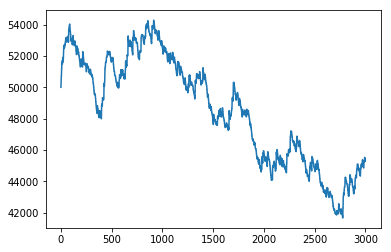

In [21]:
df.funds.plot()

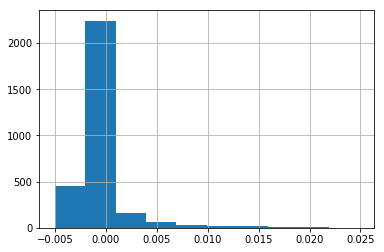

In [22]:
(df.funds.diff()/df.funds).hist()

In [23]:
rdf = df[df.substep == 3].copy()

In [24]:
rdf['token_wts'] = (rdf.tokens/rdf.supply)
rdf['wt_mean_price'] = (rdf.token_wts*rdf.prices).apply(sum)

In [25]:
rdf['holding_wts'] = (rdf.holdings/rdf.holdings.apply(sum))
rdf['h_wt_mean_price'] = (rdf.holding_wts*rdf.prices).apply(sum)

In [26]:
rdf['wealth'] = rdf.holdings + rdf.spot_price*rdf.tokens

In [27]:
rdf['wealth_wts'] = rdf.wealth/rdf.wealth.apply(sum)
rdf['w_wt_mean_price'] = (rdf.wealth_wts*rdf.prices).apply(sum)

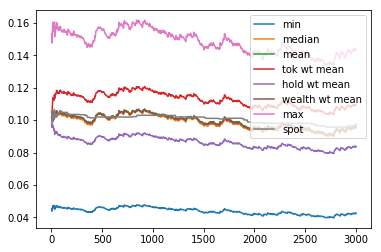

In [28]:
rdf.prices.apply(np.min).plot()
rdf.prices.apply(np.median).plot()
rdf.prices.apply(np.mean).plot()
rdf.wt_mean_price.plot()
rdf.h_wt_mean_price.plot()
rdf.w_wt_mean_price.plot()
rdf.prices.apply(np.max).plot()
rdf.spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

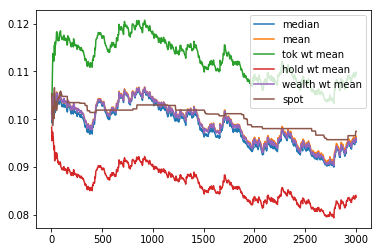

In [29]:
rdf.prices.apply(np.median).plot()
rdf.prices.apply(np.mean).plot()
rdf.wt_mean_price.plot()
rdf.h_wt_mean_price.plot()
rdf.w_wt_mean_price.plot()
rdf.spot_price.plot()
plt.legend(['median','mean','tok wt mean','hold wt mean','wealth wt mean', 'spot'])

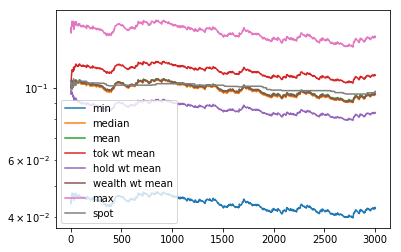

In [30]:
rdf.prices.apply(np.min).plot(logy=True)
rdf.prices.apply(np.median).plot(logy=True)
rdf.prices.apply(np.mean).plot(logy=True)
rdf.wt_mean_price.plot(logy=True)
rdf.h_wt_mean_price.plot(logy=True)
rdf.w_wt_mean_price.plot(logy=True)
rdf.prices.apply(np.max).plot(logy=True)
rdf.spot_price.plot(logy=True)
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

In [31]:
rdf['median_price']=rdf.prices.apply(np.median)
rdf['mean_price']=rdf.prices.apply(np.mean)

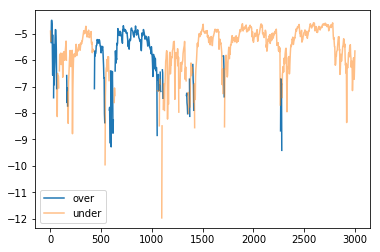

In [32]:
(np.sign(rdf['mean_price']-rdf['spot_price'])*(rdf['mean_price']-rdf['spot_price'])**2).apply(np.log10).plot(alpha=1)
(-np.sign(rdf['mean_price']-rdf['spot_price'])*(rdf['mean_price']-rdf['spot_price'])**2).apply(np.log10).plot(alpha=.5)
plt.legend(['over','under'])

In [33]:
rdf['est_err'] = rdf.spot_price - rdf.wt_mean_price
rdf['sq_est_err'] = rdf['est_err']**2

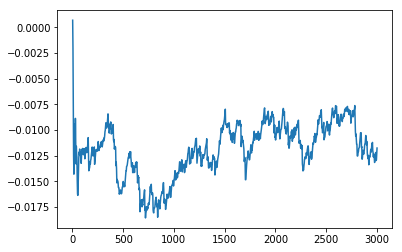

In [34]:
rdf.est_err.plot()

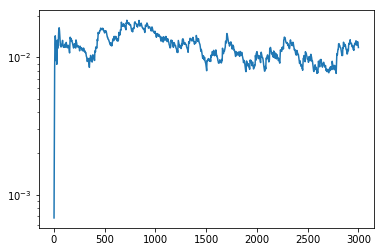

In [35]:
rdf.est_err.apply(np.abs).plot(logy=True)

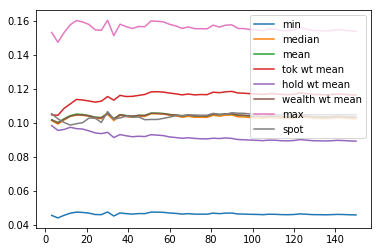

In [36]:
#head T
T = 50
rdf.head(T).prices.apply(np.min).plot()
rdf.head(T).prices.apply(np.median).plot()
rdf.head(T).prices.apply(np.mean).plot()
rdf.head(T).wt_mean_price.plot()
rdf.head(T).h_wt_mean_price.plot()
rdf.head(T).w_wt_mean_price.plot()
rdf.head(T).prices.apply(np.max).plot()
rdf.head(T).spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

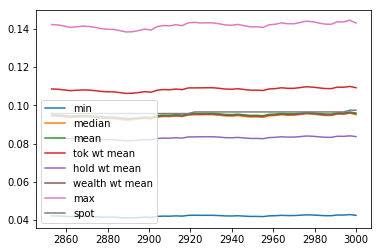

In [37]:
T = 50
rdf.tail(T).prices.apply(np.min).plot()
rdf.tail(T).prices.apply(np.median).plot()
rdf.tail(T).prices.apply(np.mean).plot()
rdf.tail(T).wt_mean_price.plot()
rdf.tail(T).h_wt_mean_price.plot()
rdf.tail(T).w_wt_mean_price.plot()
rdf.tail(T).prices.apply(np.max).plot()
rdf.tail(T).spot_price.plot()
plt.legend(['min', 'median','mean','tok wt mean','hold wt mean','wealth wt mean','max', 'spot'])

In [38]:
tx_data = rdf.actions.values
transactions = []
states = []
for t in range(time_periods_per_run):
    for tx in range(len(tx_data[t])):
        states.append(tx_data[t][tx]['posterior'])
        transactions.append(tx_data[t][tx])


In [39]:
sdf = pd.DataFrame(states)
tdf = pd.DataFrame(transactions).drop('posterior', axis=1)

In [40]:
ind=tdf[tdf.amt==0].index
tdf.drop(ind, inplace=True)
sdf.drop(ind, inplace=True)

In [41]:
tx_summary=tdf[['agent','mech','pbar','amt']].groupby(['agent','mech']).agg(['median','count']).T.iloc[:-1].T

In [42]:
tx_summary

pbar                  amt
              median  count        median
agent mech                               
0     bond  0.102966    1.0  7.362480e+02
1     bond  0.103447    1.0  2.825452e+02
2     burn  0.098400    2.0  5.244003e+03
3     burn  0.099083    1.0  4.877545e+03
4     burn  0.098867    2.0  1.097211e+04
5     bond  0.101603    5.0  5.599257e+00
      burn  0.101869  265.0  1.131081e-09
6     bond  0.104428    1.0  3.152214e+02
7     bond  0.103046    1.0  5.276548e+02
8     burn  0.093114    1.0  5.447422e+03
9     bond  0.102133    1.0  4.498114e+02
10    bond  0.098958   13.0  3.110472e-10
      burn  0.100149  106.0  4.141129e-10
11    bond  0.103981    1.0  9.387898e+02
12    bond  0.101096   15.0  3.386958e-10
      burn  0.100513  212.0  8.880837e-10
13    bond  0.106203    1.0  1.930201e+02
14    bond  0.102854    1.0  1.029592e+03
15    bond  0.103371    1.0  1.985819e+02
16    bond  0.103741    1.0  5.168417e+02
17    burn  0.093973    1.0  1.019446e+04
18    burn  0.095690    1.0  7.899205e+03
19    bond  0.102631    1.0  6.185530e+02
20    burn  0.096075    1.0  7.544406e+03
21    burn  0.095299    1.0  1.701335e+04
22    burn  0.094255    1.0  1.134473e+04
23    burn  0.097992    1.0  7.991649e+03
24    bond  0.102103    1.0  1.373723e+03
25    burn  0.095450    1.0  1.380708e+04
26    bond  0.098829    1.0  8.281099e+02
...              ...    ...           ...
74    bond  0.102840    1.0  1.855256e+02
75    burn  0.096480    1.0  7.810143e+03
76    bond  0.098958   17.0  1.175067e-10
      burn  0.101507  147.0  9.928291e-10
77    burn  0.097474    1.0  1.178674e+04
78    bond  0.100599    1.0  8.612138e+02
79    burn  0.097963    1.0  1.579843e+04
80    burn  0.099392    1.0  5.983250e+03
81    bond  0.104624    1.0  5.459903e+03
82    bond  0.105843    1.0  8.660313e+02
83    burn  0.100517    1.0  5.308744e+03
84    burn  0.098437    1.0  8.496015e+03
85    burn  0.100363    1.0  5.671962e+03
86    bond  0.099603    1.0  1.131459e+03
87    bond  0.099318   13.0  4.631147e-10
      burn  0.098886   73.0  1.009676e-09
88    bond  0.100026    1.0  1.114037e+03
89    bond  0.097015    8.0  1.831722e-10
      burn  0.099259   13.0  7.862120e-10
90    burn  0.100537    1.0  7.891134e+03
91    bond  0.099319    1.0  1.596289e+02
      burn  0.101343  150.0  1.253326e-09
92    bond  0.102540    1.0  2.074433e+02
93    burn  0.096081    1.0  1.926581e+04
94    bond  0.106403    1.0  2.325829e+02
95    bond  0.102380    1.0  1.208528e+02
96    burn  0.094699    1.0  1.296405e+04
97    burn  0.100323    1.0  1.876865e+04
98    burn  0.100486    1.0  1.631227e+04
99    burn  0.100702    1.0  4.996715e+03

[112 rows x 3 columns]

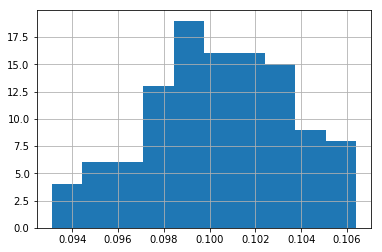

In [43]:
tx_summary.pbar['median'].hist()

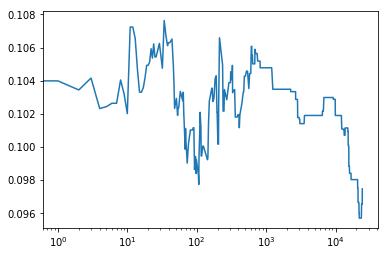

In [44]:
sdf['P'].plot(logx=True)

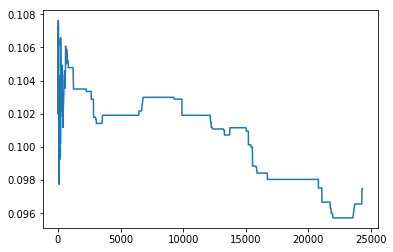

In [45]:
sdf['P'].plot()

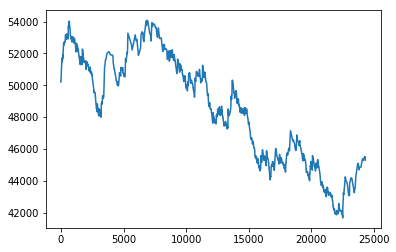

In [46]:
sdf.F.plot()

In [47]:
bond_amts = [tdf.iloc[k].amt for k in range(time_periods_per_run) if tdf.iloc[k].mech=='bond']
burn_amts = [tdf.iloc[k].amt for k in range(time_periods_per_run) if tdf.iloc[k].mech=='burn']

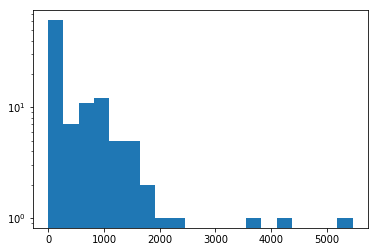

In [48]:
plt.hist(bond_amts, bins=20)
plt.yscale('log')

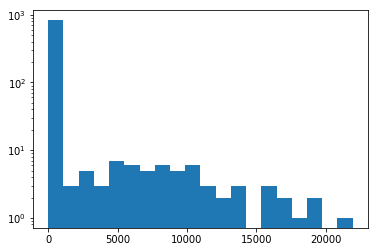

In [49]:
plt.hist(burn_amts, bins=20)
plt.yscale('log')

In [50]:
rdf['invariant'] = rdf.supply.apply(lambda x: x**kappa)/rdf.reserve

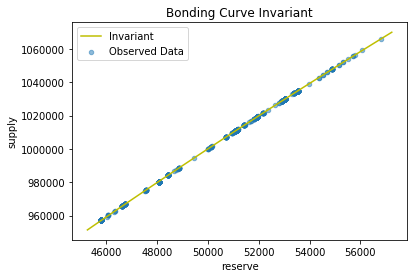

In [51]:
rdf.plot(x='reserve', y='supply', kind='scatter', alpha=.5)
axis = plt.axis()
xrange = np.arange(axis[0], axis[1], (axis[1]-axis[0])/100)
yrange = np.array([supply(x, V0, kappa) for x in xrange ])
plt.plot(xrange, yrange, 'y')
plt.title('Bonding Curve Invariant')
plt.legend(['Invariant', 'Observed Data'])

In [52]:
def gini(x):

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

(array([48.,  6., 12., 11., 12.,  3.,  5.,  1.,  0.,  2.]),
 array([   0.        ,  519.46310197, 1038.92620394, 1558.38930591,
        2077.85240788, 2597.31550985, 3116.77861182, 3636.24171379,
        4155.70481576, 4675.16791773, 5194.6310197 ]),
 <a list of 10 Patch objects>)

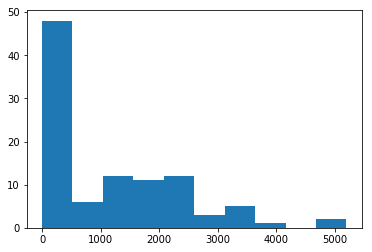

In [53]:
plt.hist(rdf.iloc[-1].holdings)

In [54]:
rdf['gini_h'] = rdf.holdings.apply(gini)

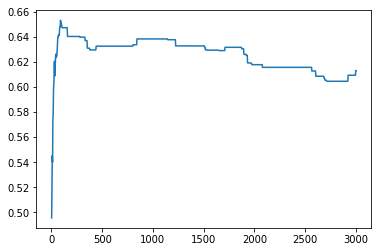

In [55]:
rdf.gini_h.plot()

(array([51., 12., 18.,  9.,  5.,  1.,  2.,  1.,  0.,  1.]),
 array([    0.        ,  6264.35577549, 12528.71155098, 18793.06732647,
        25057.42310196, 31321.77887745, 37586.13465294, 43850.49042843,
        50114.84620392, 56379.20197941, 62643.5577549 ]),
 <a list of 10 Patch objects>)

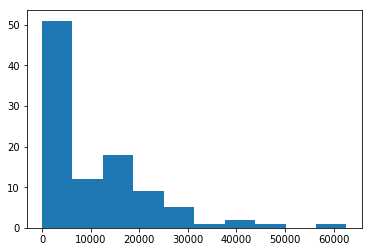

In [56]:
plt.hist(rdf.iloc[-1].tokens)

In [57]:
rdf['gini_s'] = rdf.tokens.apply(gini)

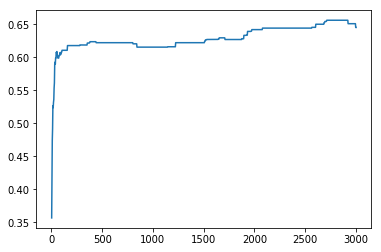

In [58]:
rdf.gini_s.plot()

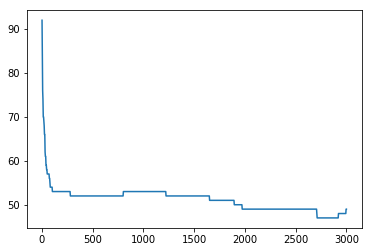

In [59]:
rdf.tokens.apply(np.count_nonzero).plot()

In [60]:
rdf['asset_value'] = rdf.holdings + rdf.spot_price*rdf.tokens

(array([20., 30., 21., 12.,  9.,  2.,  2.,  1.,  2.,  1.]),
 array([ 669.66474558, 1213.34914015, 1757.03353473, 2300.7179293 ,
        2844.40232387, 3388.08671844, 3931.77111301, 4475.45550759,
        5019.13990216, 5562.82429673, 6106.5086913 ]),
 <a list of 10 Patch objects>)

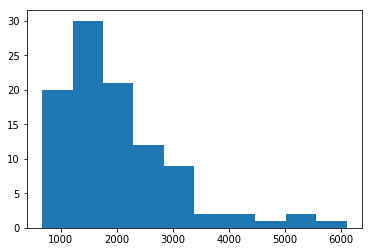

In [61]:
plt.hist(rdf.iloc[-1].asset_value)

In [62]:
rdf['gini'] = rdf.asset_value.apply(gini)

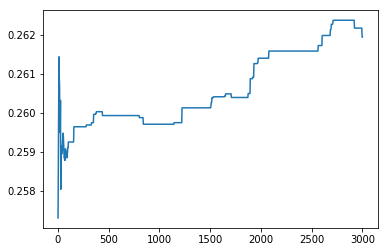

In [63]:
rdf.gini.plot()

In [64]:
rdf['pref_gap'] = (rdf.prices - rdf.spot_price)/rdf.spot_price

([array([ 1.,  5., 21., 30., 34.,  7.,  2.]),
  array([ 1.,  5., 21., 30., 35.,  6.,  2.]),
  array([ 1.,  5., 21., 30., 35.,  6.,  2.]),
  array([ 1.,  5., 20., 31., 34.,  7.,  2.]),
  array([ 1.,  5., 20., 31., 34.,  7.,  2.]),
  array([ 1.,  5., 21., 30., 34.,  7.,  2.]),
  array([ 1.,  7., 19., 30., 35.,  6.,  2.])],
 array([-0.56435314, -0.4139288 , -0.26350445, -0.1130801 ,  0.03734424,
         0.18776859,  0.33819293,  0.48861728]),
 <a list of 7 Lists of Patches objects>)

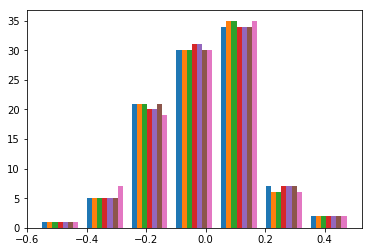

In [65]:
plt.hist(rdf.iloc[-7:].pref_gap, bins=7)